In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

In [2]:
fp = os.path.join(os.path.dirname(os.path.realpath('eda.ipynb')) + '/cleaned_runway.csv')

In [3]:
runway = pd.read_csv(fp)
runway.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,year,month
0,fit,420272,d,2260466,137.0,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14,28.0,2016,4
1,fit,273551,b,153475,132.0,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36.0,2013,6
2,fit,909926,c,126335,135.0,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34.0,2014,2
3,fit,151944,b,616682,145.0,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27.0,2016,9
4,fit,734848,b,364092,138.0,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,68.0,8,45.0,2016,4


In [4]:
runway.dtypes

fit                object
user_id             int64
bust size          object
item_id             int64
weight            float64
rating            float64
rented for         object
review_text        object
body type          object
review_summary     object
category           object
height            float64
size                int64
age               float64
year                int64
month               int64
dtype: object

In [5]:
runway.shape

(146381, 16)

In [6]:
runway.isna().sum()

fit                 0
user_id             0
bust size           0
item_id             0
weight              0
rating              0
rented for          0
review_text        36
body type           0
review_summary    229
category            0
height              0
size                0
age                 0
year                0
month               0
dtype: int64

In [7]:
# NLP techniques can be used on review_summary and review_text!

In [8]:
runway.describe()

,user_id,item_id,weight,rating,height,size,age,year,month
count,146381.000000,1.463810e+05,146381.000000,146381.000000,146381.000000,146381.000000,146381.000000,146381.000000,146381.000000
mean,498991.574528,1.052277e+06,137.209870,9.081985,65.263053,11.437919,34.089800,2015.682001,6.832123
std,289658.524623,8.091076e+05,21.540182,1.437853,2.659230,7.826784,8.113217,1.330762,3.380613
min,9.000000,1.233730e+05,50.000000,2.000000,54.000000,0.000000,0.000000,2011.000000,1.000000
25%,249294.000000,1.956130e+05,123.000000,8.000000,63.000000,4.000000,29.000000,2015.000000,4.000000
50%,499034.000000,9.618190e+05,135.000000,10.000000,65.000000,9.000000,32.000000,2016.000000,7.000000
75%,750840.000000,1.687082e+06,148.000000,10.000000,67.000000,16.000000,37.000000,2017.000000,10.000000
max,999997.000000,2.966087e+06,300.000000,10.000000,78.000000,58.000000,117.000000,2018.000000,12.000000


In [9]:
# Investigate what might be worth setting as label outcome
print(runway['category'].nunique())
runway['category'].value_counts()
# with many categories, this attribute may be useful in something like word2vec for decided label outcome

68


dress           70474
gown            33278
sheath          14691
shift            4039
jumpsuit         4019
                ...  
sweatershirt        3
overcoat            1
crewneck            1
buttondown          1
sweatpants          1
Name: category, Length: 68, dtype: int64

In [10]:
# 68 unique categories difficult to predict, explore other categorical attributes
runway['rented for'].value_counts()
# only 8 categories! For simplicity, we'll attempt to build a model to predict "rented for"!

wedding          42622
formal affair    30496
party            27198
everyday         13263
work             12124
other            11511
date              5929
vacation          3238
Name: rented for, dtype: int64

<AxesSubplot: title={'center': 'Rented For Proportions'}>

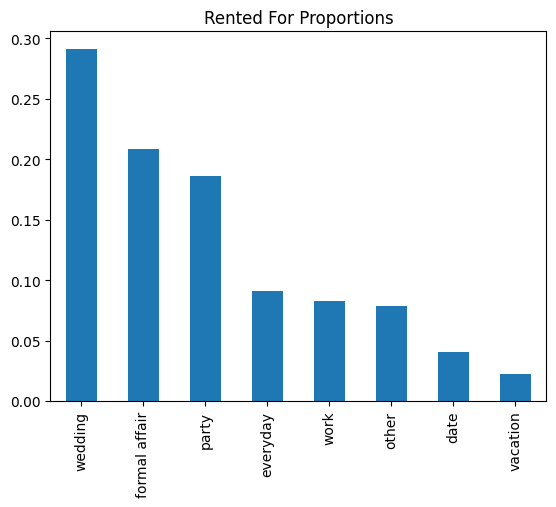

In [11]:
runway['rented for'].value_counts(normalize = True).plot(kind = 'bar', title = "Rented For Proportions")

<AxesSubplot: title={'center': 'age'}, xlabel='rented for'>

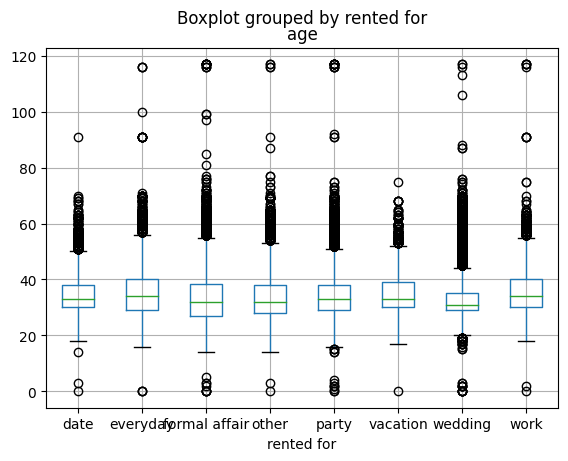

In [12]:
# are there general differences in ages between rentals for different event types?
runway.boxplot(column = 'age', by = 'rented for')
# very slight differences in ages of buyers, likely not worth keeping in model dev

In [13]:
# run pearson chi-square test on ages between rented for categories
expected = runway['age'].mean()
age_means = runway.groupby('rented for')['age'].mean().values
data = [[expected] * len(age_means), list(age_means)]
stat, p, dof, expected = chi2_contingency(data)
p
# chi square test confirms

0.9999977600592802

In [14]:
# it might make more sense to test each event type against all others using hypothesis testing
def hypothesis_test(att, event_type, alpha_level):
    filtered = runway[runway['rented for'] == event_type][att]
    others = runway[runway['rented for'] != event_type][att]
    p_val = ttest_ind(filtered, others, equal_var = False).pvalue
    print(event_type + " vs. all other event types for " + att)
    print("-------------------------------------")
    print("p-value: " + str(p_val))
    if p_val < alpha_level:
        print("reject the null hypothesis; likely different distributions\n")
    else:
        print("do not reject null hypothesis; likely same distributions\n")

In [15]:
rented_for = runway['rented for'].unique()

In [16]:
for event in rented_for:
    hypothesis_test('age', event, 0.01)
# significance seen in almost all event types

vacation vs. all other event types for age
-------------------------------------
p-value: 5.329636729505419e-16
reject the null hypothesis; likely different distributions

other vs. all other event types for age
-------------------------------------
p-value: 0.9931075090016902
do not reject null hypothesis; likely same distributions

formal affair vs. all other event types for age
-------------------------------------
p-value: 1.3334422902192682e-08
reject the null hypothesis; likely different distributions

wedding vs. all other event types for age
-------------------------------------
p-value: 0.0
reject the null hypothesis; likely different distributions

date vs. all other event types for age
-------------------------------------
p-value: 1.684371416074836e-13
reject the null hypothesis; likely different distributions

everyday vs. all other event types for age
-------------------------------------
p-value: 4.018408414047434e-107
reject the null hypothesis; likely different distrib

<AxesSubplot: title={'center': 'size'}, xlabel='rented for'>

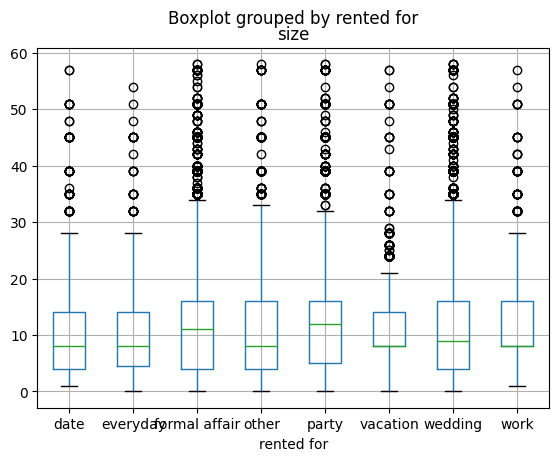

In [17]:
# do people who buy for certain events tend to wear larger/smaller sizes?
runway.boxplot(column = 'size', by = 'rented for')
# There are large enough visual differences to motivate including size in model

In [18]:
for event in rented_for:
    hypothesis_test('size', event, 0.01)

vacation vs. all other event types for size
-------------------------------------
p-value: 0.3688448553583613
do not reject null hypothesis; likely same distributions

other vs. all other event types for size
-------------------------------------
p-value: 4.408711948397743e-07
reject the null hypothesis; likely different distributions

formal affair vs. all other event types for size
-------------------------------------
p-value: 1.0486914491729215e-22
reject the null hypothesis; likely different distributions

wedding vs. all other event types for size
-------------------------------------
p-value: 0.00702138557736376
reject the null hypothesis; likely different distributions

date vs. all other event types for size
-------------------------------------
p-value: 1.6924308197513476e-06
reject the null hypothesis; likely different distributions

everyday vs. all other event types for size
-------------------------------------
p-value: 1.3651489187792234e-44
reject the null hypothesis; l

<AxesSubplot: title={'center': 'height'}, xlabel='rented for'>

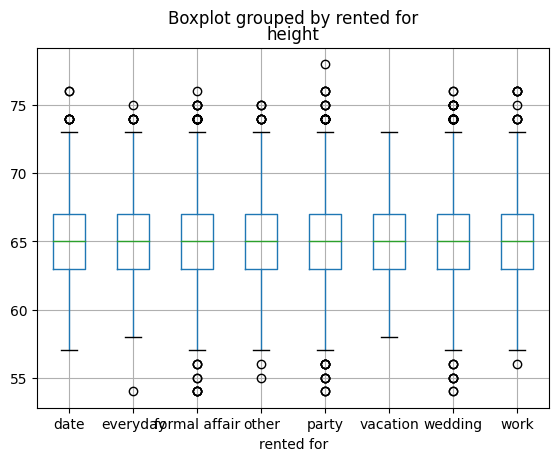

In [19]:
runway.boxplot(column = 'height', by = 'rented for')
# heights look very similar

In [20]:
for event in rented_for:
    hypothesis_test('height', event, 0.01)

vacation vs. all other event types for height
-------------------------------------
p-value: 0.060606051167008804
do not reject null hypothesis; likely same distributions

other vs. all other event types for height
-------------------------------------
p-value: 3.853968589876808e-11
reject the null hypothesis; likely different distributions

formal affair vs. all other event types for height
-------------------------------------
p-value: 2.947096412016116e-16
reject the null hypothesis; likely different distributions

wedding vs. all other event types for height
-------------------------------------
p-value: 1.6620229327528638e-14
reject the null hypothesis; likely different distributions

date vs. all other event types for height
-------------------------------------
p-value: 0.0710227093907967
do not reject null hypothesis; likely same distributions

everyday vs. all other event types for height
-------------------------------------
p-value: 1.9320058119250788e-07
reject the null hyp

<AxesSubplot: title={'center': 'weight'}, xlabel='rented for'>

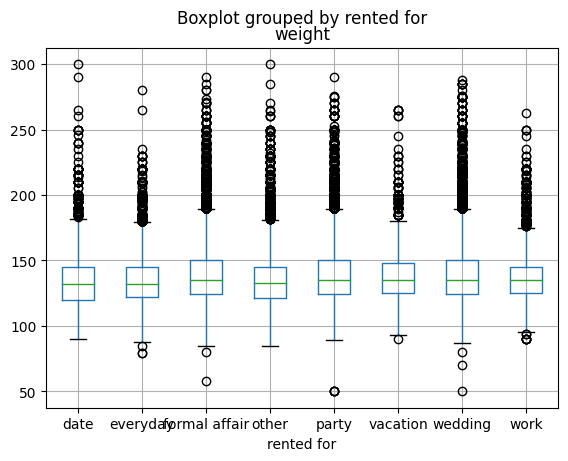

In [21]:
runway.boxplot(column = 'weight', by = 'rented for')
# weight also look very similar

In [22]:
for event in rented_for:
    hypothesis_test('weight', event, 0.01)

vacation vs. all other event types for weight
-------------------------------------
p-value: 0.8760455363919377
do not reject null hypothesis; likely same distributions

other vs. all other event types for weight
-------------------------------------
p-value: 4.1855805284121946e-09
reject the null hypothesis; likely different distributions

formal affair vs. all other event types for weight
-------------------------------------
p-value: 1.6180004904823858e-21
reject the null hypothesis; likely different distributions

wedding vs. all other event types for weight
-------------------------------------
p-value: 6.603409425710091e-08
reject the null hypothesis; likely different distributions

date vs. all other event types for weight
-------------------------------------
p-value: 3.603139433659713e-14
reject the null hypothesis; likely different distributions

everyday vs. all other event types for weight
-------------------------------------
p-value: 2.0542908746983233e-30
reject the null

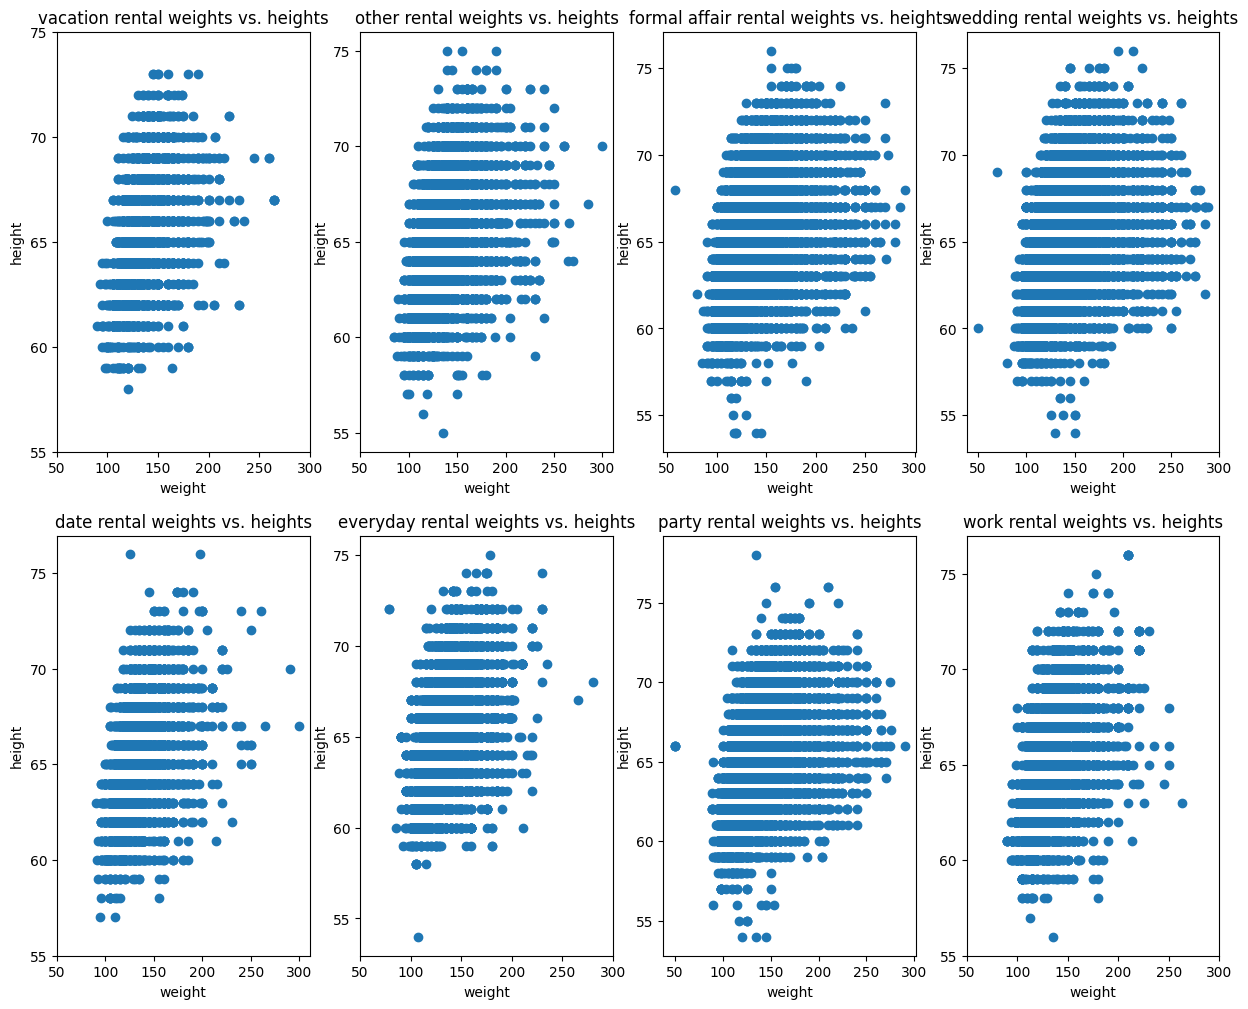

In [23]:
# construct plots for each event type of buyers' weights vs. heights
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 12))
for event, ax in zip(rented_for, axs.ravel()):
    filtered = runway[runway['rented for'] == event]
    ax.scatter(filtered.weight, filtered.height)
    ax.title.set_text(event + " rental weights vs. heights")
    ax.set_yticks([i for i in range(55, 80, 5)])
    ax.set_xticks([i for i in range(50, 350, 50)])
    ax.set_xlabel('weight')
    ax.set_ylabel('height')
# many distributions appear to have larger spreads, even if they are outliers

In [24]:
# how much of each type of clothing is purchased for each event type?
clothing_event = runway.groupby(['rented for', 'category'])['fit'].count().unstack().fillna(0)
clothing_event

category,ballgown,blazer,blouse,blouson,bomber,buttondown,caftan,cami,cape,cardigan,...,tank,tee,tight,top,trench,trouser,trousers,tunic,turtleneck,vest
rented for,,,,,,,,,,,,,,,,,,,,,
date,0.0,24.0,42.0,2.0,4.0,0.0,0.0,1.0,1.0,3.0,...,18.0,0.0,0.0,352.0,0.0,0.0,0.0,8.0,1.0,3.0
everyday,0.0,142.0,236.0,4.0,78.0,1.0,0.0,8.0,44.0,160.0,...,66.0,16.0,10.0,1754.0,16.0,18.0,3.0,75.0,14.0,154.0
formal affair,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,30.0,0.0,0.0,1.0,0.0,0.0,1.0
other,0.0,68.0,22.0,1.0,4.0,0.0,0.0,1.0,1.0,6.0,...,7.0,0.0,2.0,184.0,0.0,1.0,1.0,10.0,0.0,10.0
party,0.0,43.0,49.0,1.0,7.0,0.0,1.0,2.0,1.0,2.0,...,32.0,1.0,0.0,421.0,1.0,0.0,4.0,18.0,1.0,10.0
vacation,0.0,13.0,17.0,0.0,5.0,0.0,3.0,0.0,4.0,4.0,...,2.0,1.0,0.0,145.0,1.0,0.0,0.0,8.0,0.0,9.0
wedding,0.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,30.0,0.0,0.0,0.0,1.0,0.0,0.0
work,0.0,313.0,123.0,1.0,4.0,0.0,0.0,0.0,13.0,20.0,...,16.0,0.0,1.0,864.0,2.0,29.0,2.0,14.0,7.0,31.0


In [25]:
# calculate proportions of clothing types for each event type
clothing_props = clothing_event / clothing_event.sum()
clothing_props

category,ballgown,blazer,blouse,blouson,bomber,buttondown,caftan,cami,cape,cardigan,...,tank,tee,tight,top,trench,trouser,trousers,tunic,turtleneck,vest
rented for,,,,,,,,,,,,,,,,,,,,,
date,0.0,0.038710,0.085714,0.2,0.039216,0.0,0.00,0.083333,0.014706,0.015385,...,0.127660,0.000000,0.000000,0.093122,0.00,0.000000,0.000000,0.059701,0.043478,0.013761
everyday,0.0,0.229032,0.481633,0.4,0.764706,1.0,0.00,0.666667,0.647059,0.820513,...,0.468085,0.888889,0.769231,0.464021,0.80,0.375000,0.272727,0.559701,0.608696,0.706422
formal affair,1.0,0.019355,0.002041,0.0,0.000000,0.0,0.00,0.000000,0.044118,0.000000,...,0.000000,0.000000,0.000000,0.007937,0.00,0.000000,0.090909,0.000000,0.000000,0.004587
other,0.0,0.109677,0.044898,0.1,0.039216,0.0,0.00,0.083333,0.014706,0.030769,...,0.049645,0.000000,0.153846,0.048677,0.00,0.020833,0.090909,0.074627,0.000000,0.045872
party,0.0,0.069355,0.100000,0.1,0.068627,0.0,0.25,0.166667,0.014706,0.010256,...,0.226950,0.055556,0.000000,0.111376,0.05,0.000000,0.363636,0.134328,0.043478,0.045872
vacation,0.0,0.020968,0.034694,0.0,0.049020,0.0,0.75,0.000000,0.058824,0.020513,...,0.014184,0.055556,0.000000,0.038360,0.05,0.000000,0.000000,0.059701,0.000000,0.041284
wedding,0.0,0.008065,0.000000,0.1,0.000000,0.0,0.00,0.000000,0.014706,0.000000,...,0.000000,0.000000,0.000000,0.007937,0.00,0.000000,0.000000,0.007463,0.000000,0.000000
work,0.0,0.504839,0.251020,0.1,0.039216,0.0,0.00,0.000000,0.191176,0.102564,...,0.113475,0.000000,0.076923,0.228571,0.10,0.604167,0.181818,0.104478,0.304348,0.142202


In [26]:
# which clothing types don't have any proportion above the threshold for any event type?
threshold = 0.3
((clothing_props < threshold).apply(all))[((clothing_props < threshold).apply(all)) == True]

category
shift     True
skirts    True
dtype: bool

In [27]:
# if the proportions of these clothings are too uniform, 
# it might be worth converting them to an "other" clothing type
clothing_props['shift']
# consists mainly of 2 event types

rented for
date             0.048279
everyday         0.063877
formal affair    0.104976
other            0.101510
party            0.273830
vacation         0.025006
wedding          0.280763
work             0.101758
Name: shift, dtype: float64

In [28]:
clothing_props['skirts']
# consists of 4 event types split evenly, this is not so bad

rented for
date             0.00
everyday         0.00
formal affair    0.25
other            0.25
party            0.25
vacation         0.00
wedding          0.00
work             0.25
Name: skirts, dtype: float64

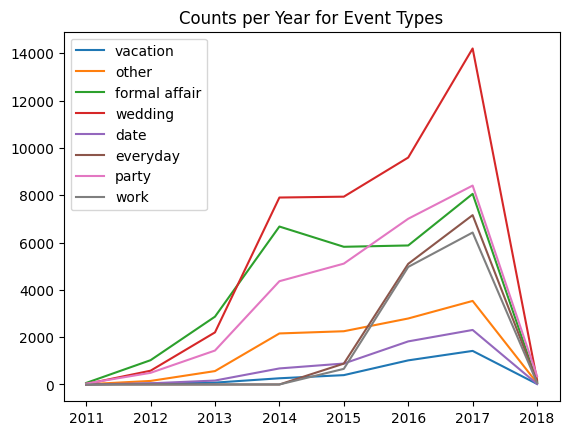

In [29]:
# how has renting for each event increased/decreased over the years?
vals = [runway.groupby(['rented for', 'year'])['fit'].count()[clothing].values for clothing in rented_for]
# fill 0 for counts of years with 0 of two "rented for" categories
vals[5] = ([0] * 4) + list(vals[5])
vals[7] = ([0] * 4) + list(vals[7])
yrs = [yr for yr in range(2011, 2019)]
for i, clothing in enumerate(rented_for):
    plt.plot(yrs, vals[i], label = clothing)
plt.title("Counts per Year for Event Types")
plt.legend()
plt.show()
# sales for certain events jump and dip certain years (more/less bought)
# this could be useful as a feature in model dev

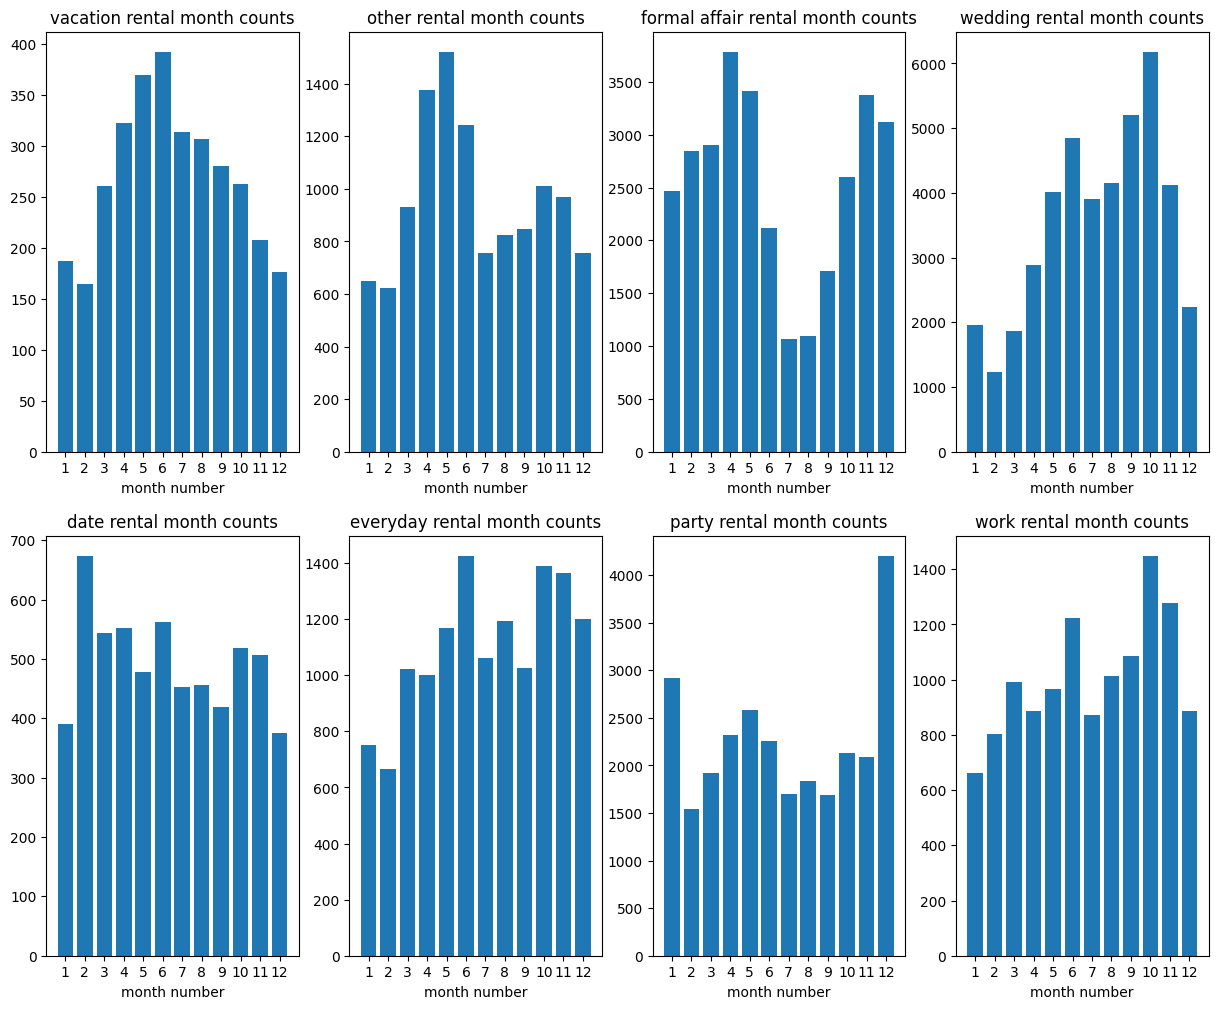

In [30]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 12))
month_counts = runway.groupby(['rented for', 'month']).count().reset_index()
for event, ax in zip(rented_for, axs.ravel()):
    df = month_counts[month_counts['rented for'] == event].set_index('month')['fit']
    ax.bar(df.index, df.values)
    ax.title.set_text(event + " rental month counts")
    ax.set_xticks([i for i in range(1, 13)])
    ax.set_xlabel("month number")
# it appears that clothing for certain event types is more commonly bought during certain months
# therefore, month is a useful attribute

In [31]:
# In order to test if distributions are significantly different, we'll use 
# a modified form of permutation testing
def permutation_test(n_trials, att, event_type, alpha_level):
    '''
    tests proportional distribution of an attribute for one event type against the
    proportional distribution of that attribute for all other event types combined
    to test if distributions are significantly different
    
    n_trials: number of permutation iterations
    att: attribute to test distributions between event types
    event_type: event type to test against all others
    '''
    # filter for only specified event type
    filtered = runway[runway['rented for'] == event_type].groupby(att).count()['category']
    filtered_props = filtered / filtered.sum()
    # filter for everything but specified event type
    not_event = runway[runway['rented for'] != event_type].groupby(att).count()['category']
    not_event_props = not_event / not_event.sum()
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
    for i, ax in enumerate(axs.ravel()):
        if i == 0:
            ax.bar(filtered_props.index, filtered_props.values)
            ax.title.set_text(event)
        if i == 1:
            ax.bar(not_event_props.index, not_event_props.values)
            ax.title.set_text("other events")
    plt.show()
    # calculate observered sum of absolute differences
    obs_error = sum(abs(filtered_props - not_event_props))
    trials = [0] * n_trials
    for i in range(n_trials):
        permuted_col = runway[att].sample(frac = 1, replace = False).values
        permuted = runway.assign(p = permuted_col)
        filtered = permuted[permuted['rented for'] == event_type].groupby('p').count()['category']
        filtered_props = filtered / filtered.sum()
        not_event = permuted[permuted['rented for'] != event_type].groupby('p').count()['category']
        not_event_props = not_event / not_event.sum()
        trials[i] = sum(abs(filtered_props - not_event_props))
    print(event_type + " vs. all other event types for " + att)
    print("-------------------------------------")
    p_val = np.count_nonzero(np.array(trials) >= obs_error) / n_trials
    print("p-value: " + str(p_val))
    if p_val < alpha_level:
        print("reject the null hypothesis; likely different distributions")
    else:
        print("do not reject null hypothesis; likely same distributions")
    

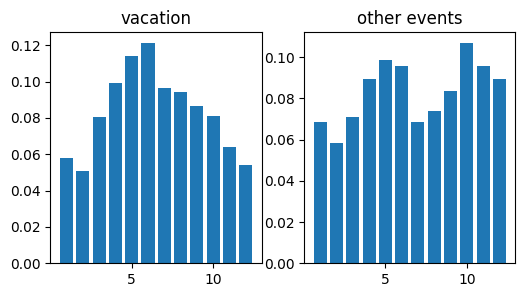

vacation vs. all other event types for month
-------------------------------------
p-value: 0.0
reject the null hypothesis; likely different distributions


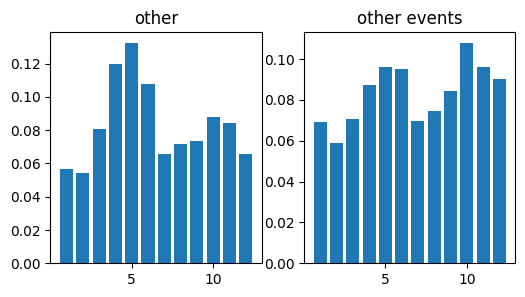

other vs. all other event types for month
-------------------------------------
p-value: 0.0
reject the null hypothesis; likely different distributions


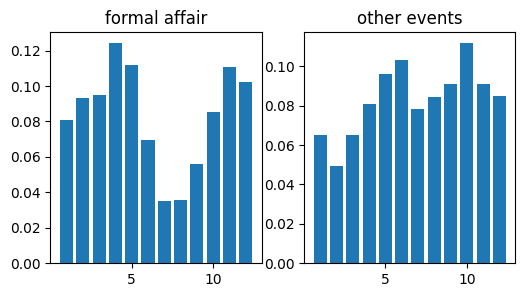

formal affair vs. all other event types for month
-------------------------------------
p-value: 0.0
reject the null hypothesis; likely different distributions


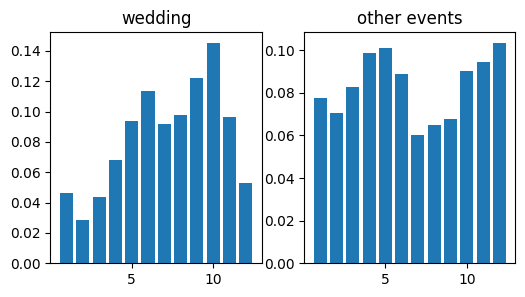

wedding vs. all other event types for month
-------------------------------------
p-value: 0.0
reject the null hypothesis; likely different distributions


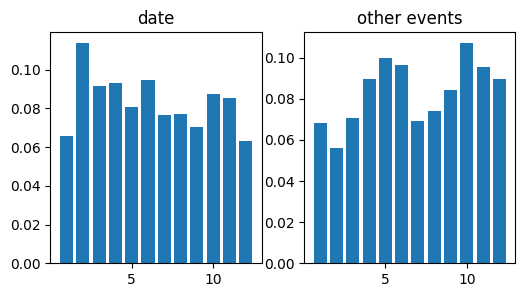

date vs. all other event types for month
-------------------------------------
p-value: 0.0
reject the null hypothesis; likely different distributions


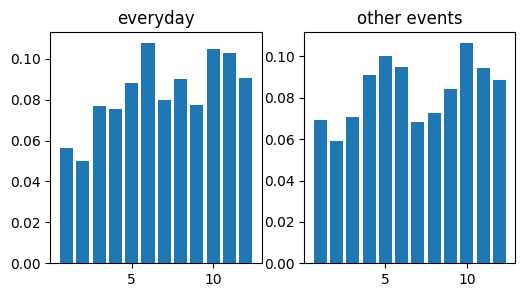

everyday vs. all other event types for month
-------------------------------------
p-value: 0.0
reject the null hypothesis; likely different distributions


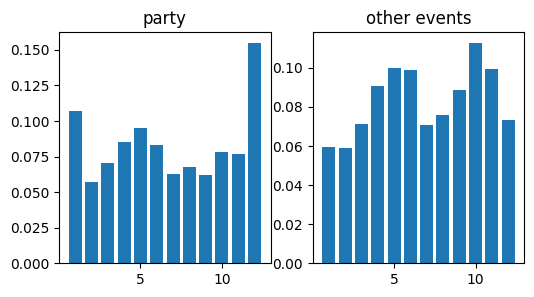

party vs. all other event types for month
-------------------------------------
p-value: 0.0
reject the null hypothesis; likely different distributions


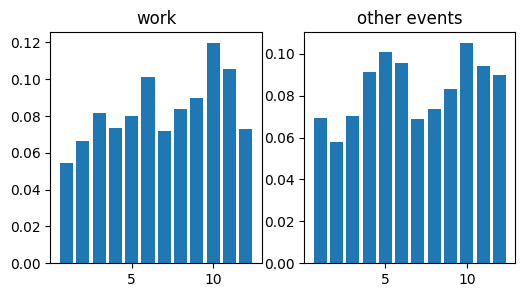

work vs. all other event types for month
-------------------------------------
p-value: 0.0
reject the null hypothesis; likely different distributions


In [32]:
for event in rented_for:
    permutation_test(200, 'month', event, 0.01)

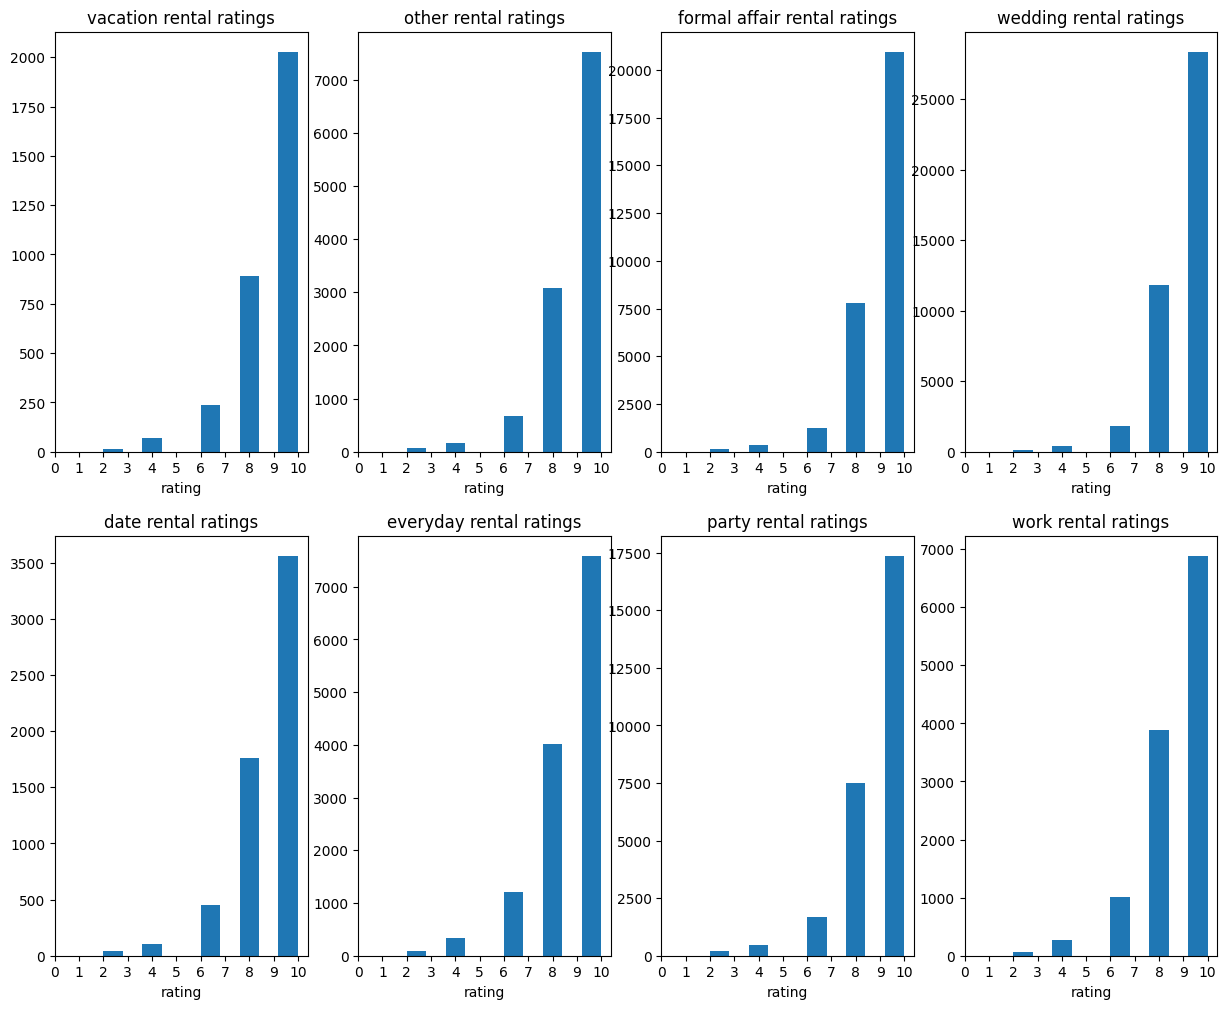

In [33]:
# Even though theoretically rating should not influence which event type was rented for, it's possible that this
# clothing renter has worse quality with certain clothing types, for example
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 12))
for event, ax in zip(rented_for, axs.ravel()):
    df = runway[runway['rented for'] == event]['rating']
    ax.hist(df.values)
    ax.title.set_text(event + " rental ratings")
    ax.set_xticks([i for i in range(0, 11)])
    ax.set_xlabel("rating")
# all event types appear to have very similar distributions of ratings; rating is likely not important

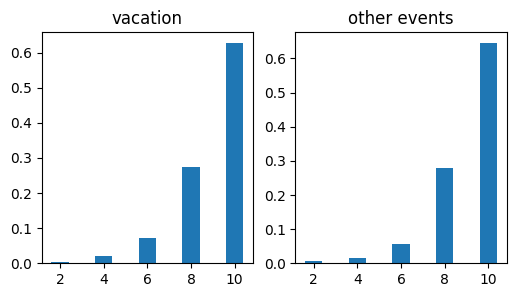

vacation vs. all other event types for rating
-------------------------------------
p-value: 0.03
do not reject null hypothesis; likely same distributions


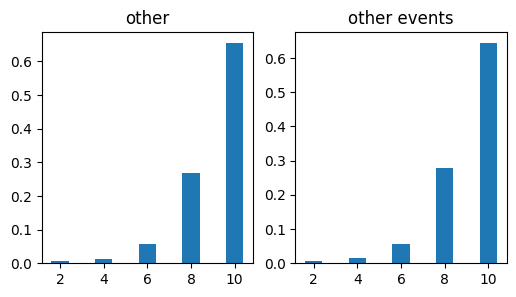

other vs. all other event types for rating
-------------------------------------
p-value: 0.01
do not reject null hypothesis; likely same distributions


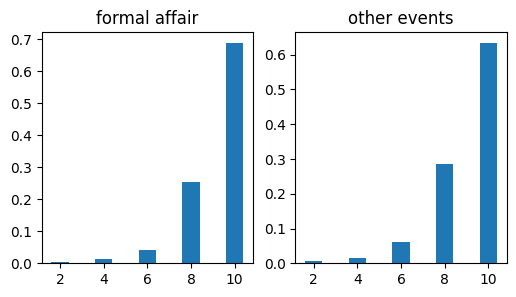

formal affair vs. all other event types for rating
-------------------------------------
p-value: 0.0
reject the null hypothesis; likely different distributions


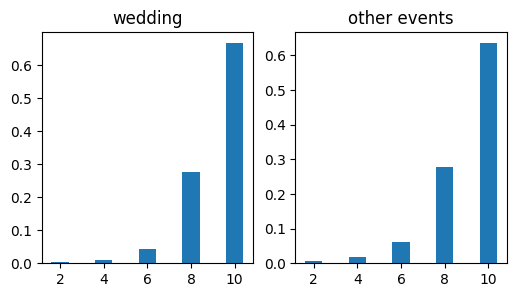

wedding vs. all other event types for rating
-------------------------------------
p-value: 0.0
reject the null hypothesis; likely different distributions


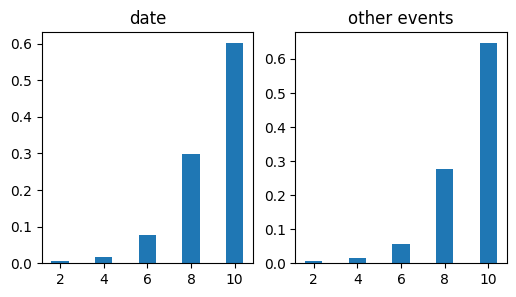

date vs. all other event types for rating
-------------------------------------
p-value: 0.0
reject the null hypothesis; likely different distributions


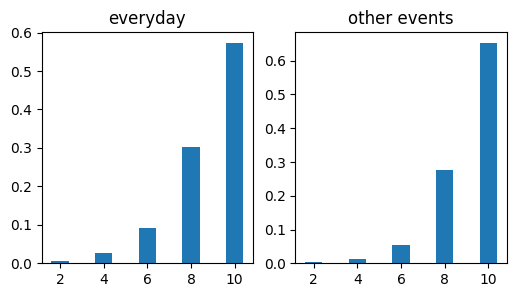

everyday vs. all other event types for rating
-------------------------------------
p-value: 0.0
reject the null hypothesis; likely different distributions


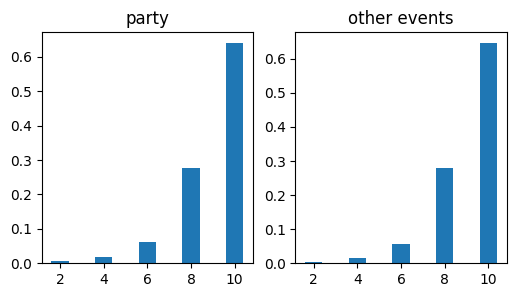

party vs. all other event types for rating
-------------------------------------
p-value: 0.0
reject the null hypothesis; likely different distributions


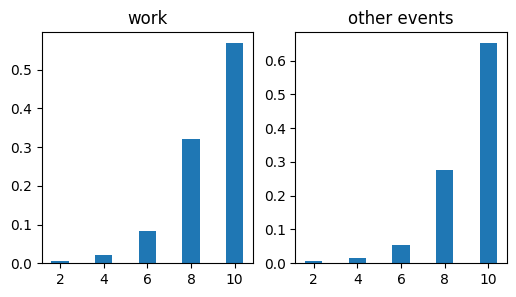

work vs. all other event types for rating
-------------------------------------
p-value: 0.0
reject the null hypothesis; likely different distributions


In [34]:
for event in rented_for:
    permutation_test(200, 'rating', event, 0.01)

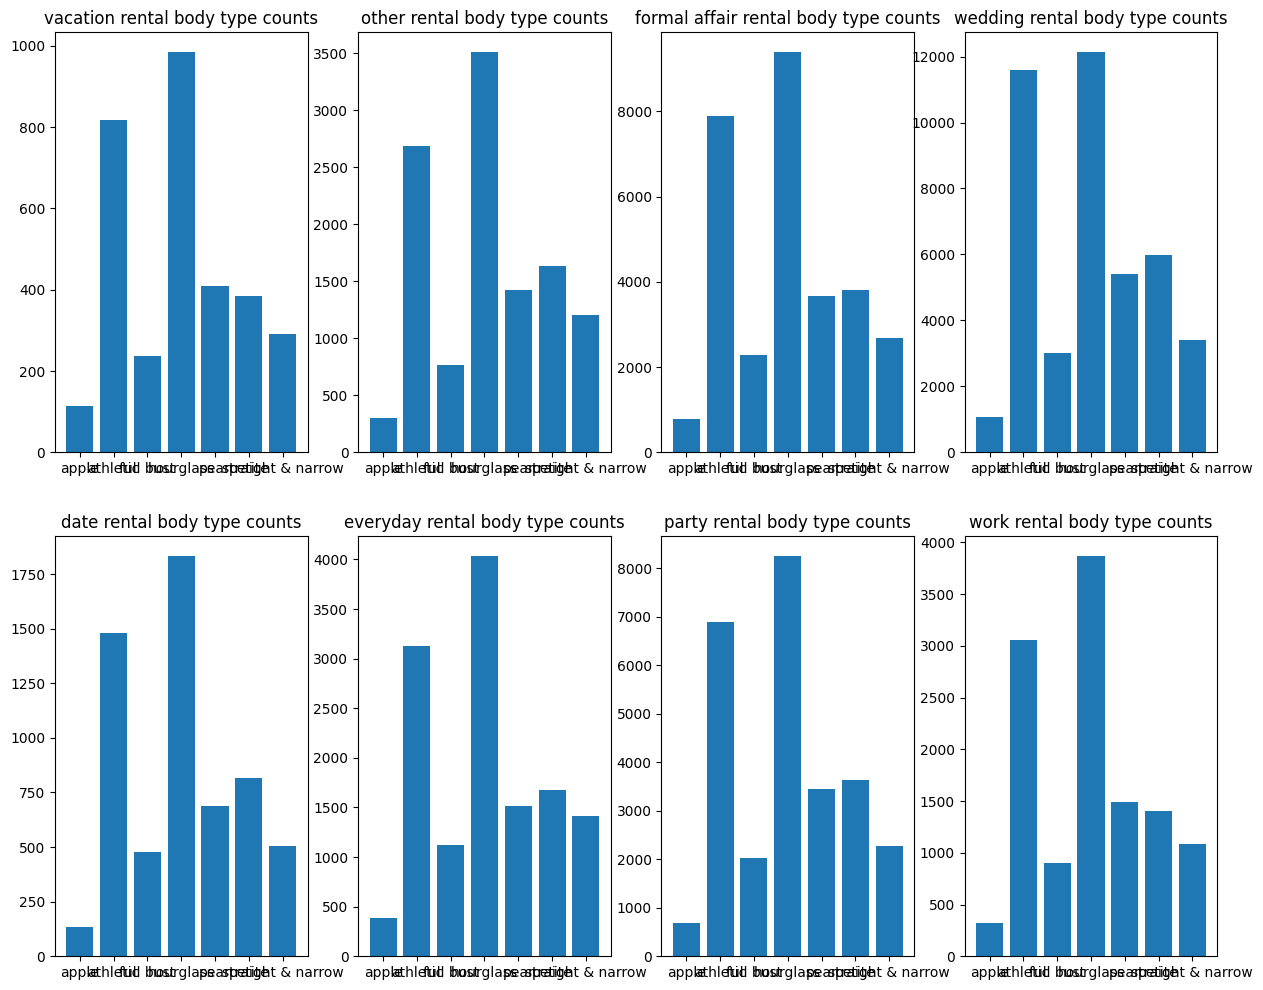

In [35]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 12))
body_counts = runway.groupby(['rented for', 'body type']).count().reset_index()
for event, ax in zip(rented_for, axs.ravel()):
    df = body_counts[body_counts['rented for'] == event].set_index('body type')['fit']
    ax.bar(df.index, df.values)
    ax.title.set_text(event + " rental body type counts")
# all of the distributions look only very slightly different, so not worth including body type

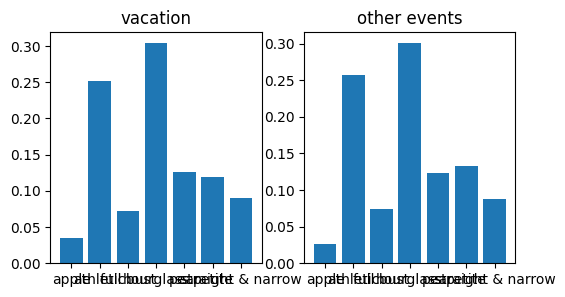

vacation vs. all other event types for body type
-------------------------------------
p-value: 0.275
do not reject null hypothesis; likely same distributions


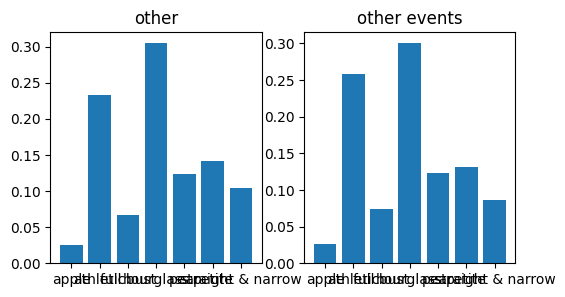

other vs. all other event types for body type
-------------------------------------
p-value: 0.0
reject the null hypothesis; likely different distributions


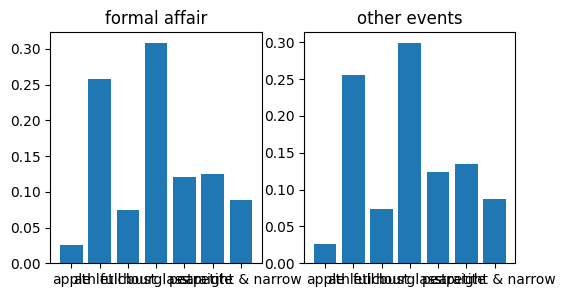

formal affair vs. all other event types for body type
-------------------------------------
p-value: 0.0
reject the null hypothesis; likely different distributions


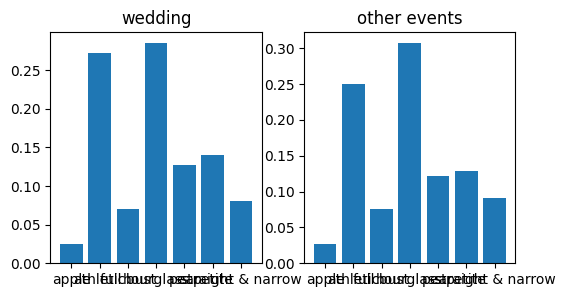

wedding vs. all other event types for body type
-------------------------------------
p-value: 0.0
reject the null hypothesis; likely different distributions


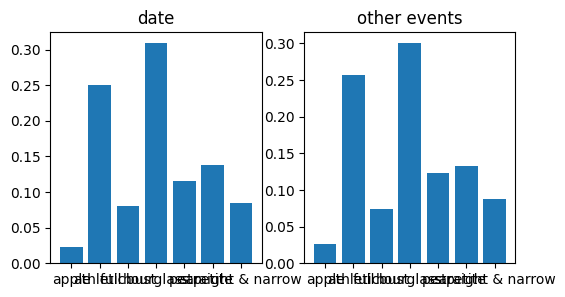

date vs. all other event types for body type
-------------------------------------
p-value: 0.025
do not reject null hypothesis; likely same distributions


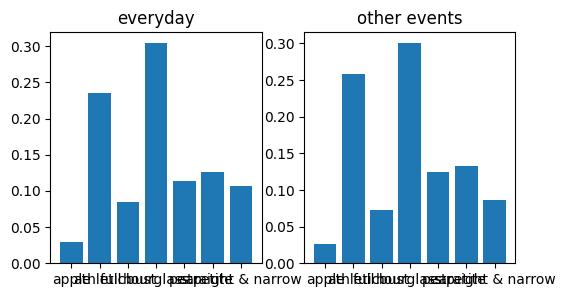

everyday vs. all other event types for body type
-------------------------------------
p-value: 0.0
reject the null hypothesis; likely different distributions


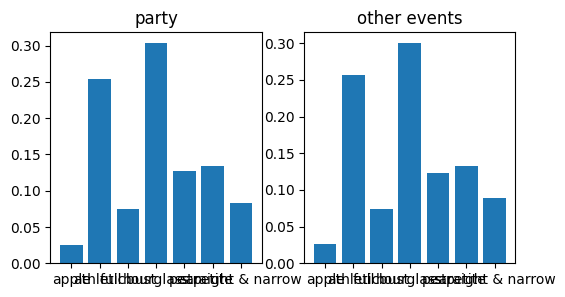

party vs. all other event types for body type
-------------------------------------
p-value: 0.02
do not reject null hypothesis; likely same distributions


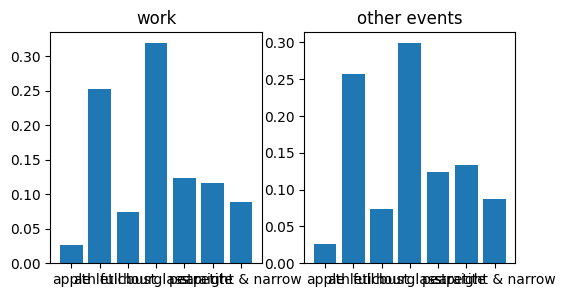

work vs. all other event types for body type
-------------------------------------
p-value: 0.0
reject the null hypothesis; likely different distributions


In [36]:
for event in rented_for:
    permutation_test(200, 'body type', event, 0.01)

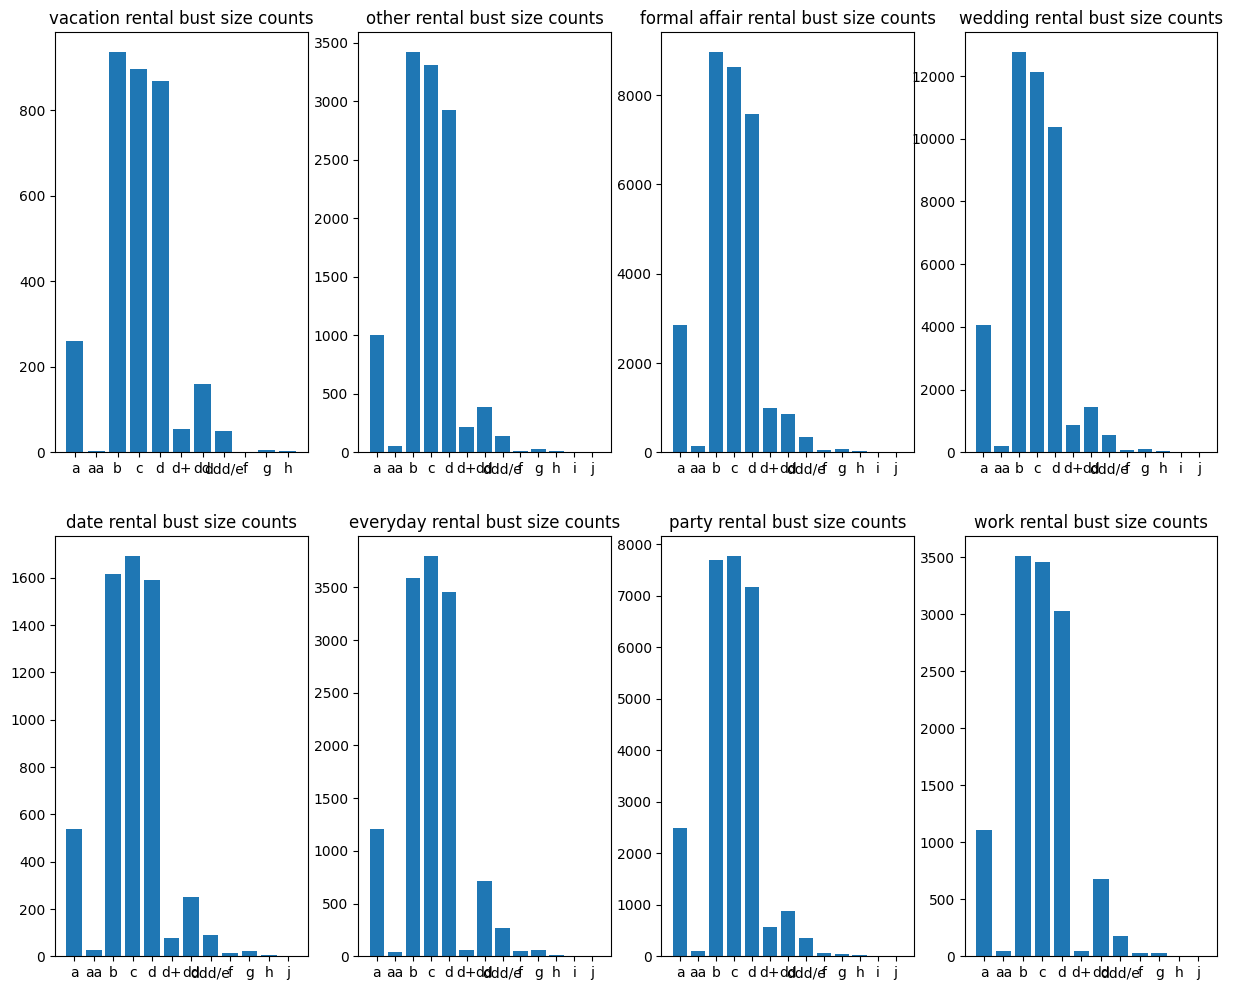

In [37]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 12))
bust_counts = runway.groupby(['rented for', 'bust size']).count().reset_index()
for event, ax in zip(rented_for, axs.ravel()):
    df = bust_counts[bust_counts['rented for'] == event].set_index('bust size')['fit']
    ax.bar(df.index, df.values)
    ax.title.set_text(event + " rental bust size counts")

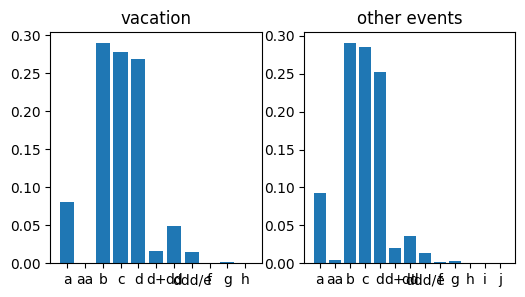

vacation vs. all other event types for bust size
-------------------------------------
p-value: 0.0
reject the null hypothesis; likely different distributions


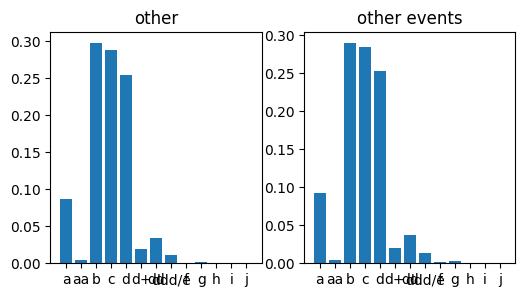

other vs. all other event types for bust size
-------------------------------------
p-value: 0.04
do not reject null hypothesis; likely same distributions


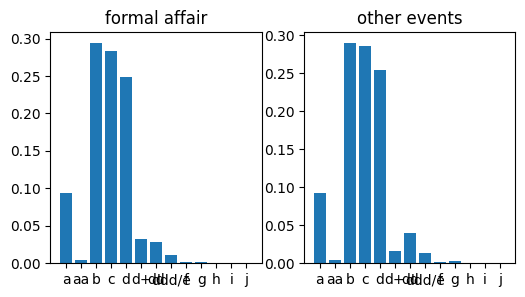

formal affair vs. all other event types for bust size
-------------------------------------
p-value: 0.0
reject the null hypothesis; likely different distributions


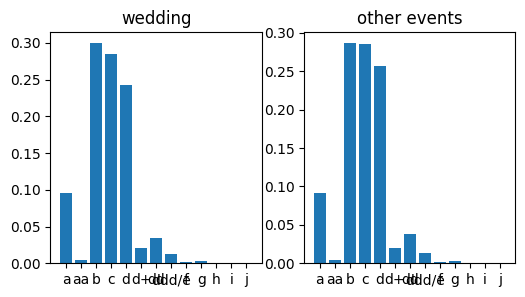

In [ ]:
for event in rented_for:
    permutation_test(200, 'bust size', event, 0.01)